# ガウス分布の学習

In [2]:
!date

2019年 8月24日 土曜日 16時47分15秒 JST


In [3]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats, special

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Data

In [4]:
N = 50
mean = 2
std = 2

data = np.random.randn(N) * std + mean

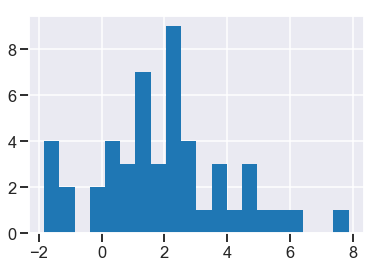

In [5]:
plt.hist(data, bins=20)
plt.show()

# 平均が未知の場合

In [16]:
class GaussMean:
    def __init__(self, mean, lmd, data_lmd, lb=-8, ub=8):
        
        self.mean = mean
        self.lmd = lmd
        self.data_lmd = data_lmd
        self.lb = lb
        self.ub = ub
        
    def sample(self, num=1):
        lmd_ast = (self.data_lmd * self.lmd 
                   * (self.data_lmd + self.lmd) ** -1)
        return np.random.randn(num) * lmd_ast ** -0.5 + self.mean
    
    def inference(self, x):
        N = len(x)
        lmd = self.lmd
        
        self.lmd = N * self.data_lmd + lmd
        self.mean = ((self.data_lmd * np.sum(x) + lmd * self.mean)
                           * self.lmd ** -1)
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        y = (np.exp(-(x - self.mean) ** 2 * self.lmd)
             * np.abs(self.lmd) ** 0.5 / np.sqrt(2 * np.pi))
            
        return x, y

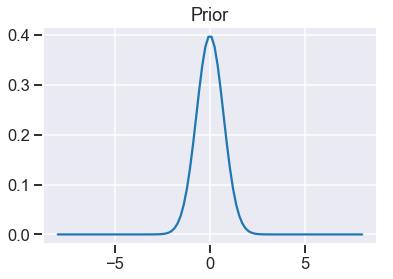

In [17]:
dist = GaussMean(0, 1, std ** -2)
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

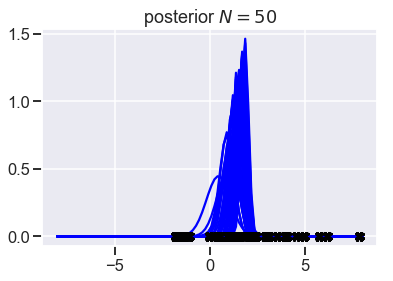

In [35]:
dist = GaussMean(0, 1, std ** -2)

frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    dist.inference(np.array([data[i]]))
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data[:i + 1], np.zeros_like(data[:i + 1]), 'X', c='k')
    frames.append(im1 + im2)

In [36]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

In [37]:
print('True mean: {}, Estimated mean: {}'.format(mean, dist.mean))

True mean: 2, Estimated mean: 1.8454140013390217


# 精度が未知の場合

In [38]:
class GaussLmd:
    def __init__(self, a, b, data_mean, lb=-8, ub=8):
        
        self.a = a
        self.b = b
        self.data_mean = data_mean
        self.lb = lb
        self.ub = ub
        
        self.mu_s = data_mean
        self.lmd_s = a / b
        self.nu_s = 2 * a
        
    def sample(self, num=1):        
        return stats.t.rvs(df=self.nu_s, loc=self.mu_s, 
                           scale=self.lmd_s, size=num)
    
    def inference(self, x):
        N = len(x)
        self.a += N / 2
        self.b += np.sum(x - self.data_mean) ** 2 / 2
        
        self.lmd_s = self.a / self.b
        self.nu_s = 2 * self.a
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        y = (special.gamma((self.nu_s + 1) / 2) 
             * special.gamma(self.nu_s / 2) ** -1
             * (self.lmd_s / (np.pi * self.nu_s)) ** 0.5
             * (1 + (x - self.mu_s) ** 2 
                * self.lmd_s / self.nu_s) ** (-(self.nu_s + 1) / 2))
            
        return x, y

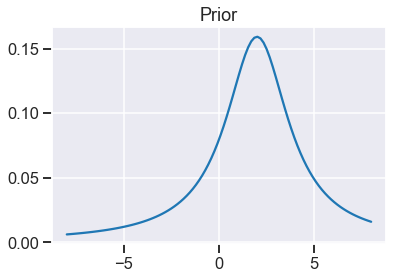

In [39]:
dist = GaussLmd(0.5, 2., mean)
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

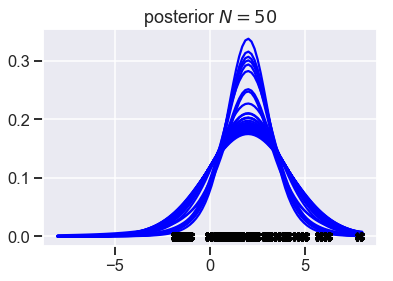

In [40]:
dist = GaussLmd(0.5, 2., mean)

frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    dist.inference(np.array([data[i]]))
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data[:i + 1], np.zeros_like(data[:i + 1]), 'X', c='k')
    frames.append(im1 + im2)

In [41]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

In [42]:
print('True lmd: {}, Estimated lmd: {}'.format(std, dist.lmd_s ** -0.5))

True lmd: 2, Estimated lmd: 2.072074164278017


# 平均・精度が未知の場合

In [51]:
class GaussMeanLmd:
    def __init__(self, m, beta, a, b, lb=-8, ub=8):
        
        self.m = m
        self.beta = beta
        self.a = a
        self.b = b
        self.lb = lb
        self.ub = ub
        
        self.mu_s = m
        self.lmd_s = a / b
        self.nu_s = 2 * a
        
    def sample(self, num=1):
        return stats.t.rvs(df=self.nu_s, loc=self.mu_s, 
                           scale=self.lmd_s, size=num)
    
    def inference(self, x):
        N = len(x)
        
        # Save prior
        beta = self.beta
        m = self.m
        
        # Update parameters
        self.beta = N + beta
        self.m = (np.sum(x) + beta * self.m) * self.beta ** -1
        self.a += N / 2
        self.b += (np.sum(x ** 2) + beta * m ** 2
                   - self.beta * self.m ** 2) / 2
        
        self.lmd_s = self.beta * self.a * ((1 + self.beta) * self.b) ** -1
        self.nu_s = 2 * self.a
        self.mu_s = self.m
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        # Student's t distribution
        y = (special.gamma((self.nu_s + 1) / 2) 
             * special.gamma(self.nu_s / 2) ** -1
             * (self.lmd_s / (np.pi * self.nu_s)) ** 0.5
             * (1 + (x - self.mu_s) ** 2 
                * self.lmd_s / self.nu_s) ** (-(self.nu_s + 1) / 2))
            
        return x, y

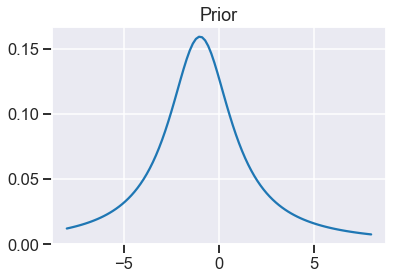

In [52]:
dist = GaussMeanLmd(-1, 1, 0.5, 2.)
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

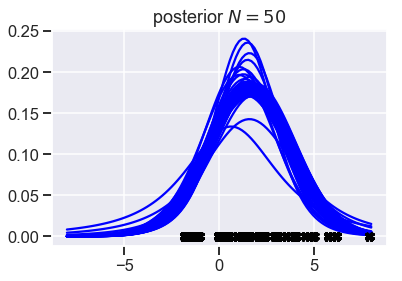

In [53]:
dist = GaussMeanLmd(-1, 1, 0.5, 2.)

frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    dist.inference(np.array([data[i]]))
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data[:i + 1], np.zeros_like(data[:i + 1]), 'X', c='k')
    frames.append(im1 + im2)

In [54]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

In [55]:
print('True mean: {}, Estimated mean: {}'.format(mean, dist.mu_s))

True mean: 2, Estimated mean: 1.9343599229864148


In [56]:
print('True lmd: {}, Estimated lmd: {}'.format(std, dist.lmd_s ** -0.5))

True lmd: 2, Estimated lmd: 2.1338264082199356
